In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab.utils.logging import ListLogger
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from tqdm import tqdm


from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import torch

from typing import Tuple, Optional
import torch
from functorch import vmap


from functools import partial


import torchsde
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable


from torchdiffeq import odeint
from torch.func import jacrev


import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE

from models.augmentation import AugmentedVectorField, CNFReg
from models.egnn import EGNN_dynamics

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [4]:
def sample_from_array(array, size):
    idx = np.random.choice(array.shape[0], size=size)
    return array[idx]

In [5]:
def get_senders_and_receivers_fully_connected(n_nodes):
    receivers = []
    senders = []
    for i in range(n_nodes):
        for j in range(n_nodes - 1):
            receivers.append(i)
            senders.append((i + 1 + j) % n_nodes)
    return torch.tensor(senders), torch.tensor(receivers)

def energy(x, epsilon= 1.0, tau= 1.0, r= 1.0, harmonic_potential_coef= 0.5):
    n_nodes, dim = x.shape
    
    if isinstance(r, float):
        r = torch.ones(n_nodes, device=device) * r
    senders, receivers = get_senders_and_receivers_fully_connected(n_nodes)
    vectors = x[senders] - x[receivers]
    d = torch.linalg.norm(vectors, ord=2, dim=-1)
    term_inside_sum = (r[receivers] / d)**12 - 2*(r[receivers] / d)**6
    energy = epsilon / (2 * tau) * term_inside_sum.sum()

    centre_of_mass = x.mean(dim=0)
    harmonic_potential = harmonic_potential_coef * (x - centre_of_mass).pow(2).sum()
    return energy + harmonic_potential


def log_prob(x: torch.Tensor):
    x = x.reshape(-1, 13, 3)
    if len(x.shape) == 2:
        return - energy(x)
    elif len(x.shape) == 3:
        return - torch.vmap(energy)(x)
    else:
        raise Exception

In [6]:
def interatomic_dist(samples):
    # Compute the pairwise differences and distances
    dist = samples[:, None, :, :] - samples[:, :, None, :]
    differences = torch.linalg.norm(dist, dim=-1)
    return differences #torch.mean(differences, dim=(1, 2))

In [7]:
def plot_sample_hist(samples, ax = None, dim=(0,1), label=None):
    if ax == None:
        fig, ax = plt.subplots()
    d = interatomic_dist(samples)
    ax.hist(d, bins=50, density=True, alpha=0.4, label=label)

## Function Definitions

### Estimated Reward Functions

In [8]:
def var_schedule(beta, t):
    return beta * t **2

def diffusion_coeff(beta, t):
    return beta * 2 * t

In [9]:
from abc import ABC, abstractmethod

class NoiseSchedule(ABC):
    @abstractmethod
    def g(t):
        # Returns g(t)
        pass
    
    @abstractmethod
    def h(t):
        # Returns \int_0^t g(t)^2 dt
        pass

    
class LinearNoiseSchedule(NoiseSchedule):
    def __init__(self, beta, norm_factor=1.0):
        self.beta = beta / norm_factor
        
    def g(self, t):
        return torch.sqrt(self.beta * 2 * t) #self.beta.sqrt()
    
    def h(self, t):
        return self.beta * t **2

class GeometricNoiseSchedule(NoiseSchedule):
    def __init__(self, sigma_min, sigma_max, norm_factor=1.0):
        self.sigma_min = sigma_min / norm_factor
        self.sigma_max = sigma_max / norm_factor
        self.sigma_diff = self.sigma_max / self.sigma_min
        
    def g(self, t):
        # Let sigma_d = sigma_max / sigma_min
        # Then g(t) = sigma_min * sigma_d^t * sqrt{2 * log(sigma_d)}
        # See Eq 192 in https://arxiv.org/pdf/2206.00364.pdf
        return self.sigma_min * (self.sigma_diff ** t) * ((2 * np.log(self.sigma_diff)) ** 0.5)
        
    def h(self, t):
        # Let sigma_d = sigma_max / sigma_min
        # Then h(t) = \int_0^t g(z)^2 dz = sigma_min * sqrt{sigma_d^{2t} - 1}
        # see Eq 199 in https://arxiv.org/pdf/2206.00364.pdf
        return (self.sigma_min * (((self.sigma_diff ** (2 * t)) - 1) ** 0.5)) ** 2

In [10]:
# calculate the log expectation of the reward
def log_E_R(_x, _t, noise_schedule, num_mc_samples, var_exploding=True):
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = noise_schedule.h(repeated_t)
    h_t = h_t.unsqueeze(1)
    if var_exploding:
        # variance exploding
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
        log_rewards = log_prob(samples)
        log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    else:
        # variance preserving
        samples = (repeated_x/torch.sqrt(1 - repeated_t.unsqueeze(1)) 
                   + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5))
        log_rewards = log_prob(samples)
        log_expectation_R = torch.log(1 / (1 - _t)) + torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    return log_expectation_R

In [11]:
def estimated_Rt(x, t, beta, num_mc_samples=100, var_exploding=True):
    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(device)
    return torch.vmap(log_E_R, randomness='different', 
                      in_dims=(0,0,None,None))(x, t, beta, num_mc_samples, var_exploding=var_exploding)

In [12]:
def estimate_grad_Rt(x, t, noise_schedule, num_mc_samples=100, var_exploding=True, richardson=False):
    est_scores_n = torch.func.grad(log_E_R)(x, t, noise_schedule, num_mc_samples, var_exploding=var_exploding)
    if richardson:
        est_scores_n_div2 = torch.func.grad(log_E_R)(x, t, noise_schedule, num_mc_samples//2, var_exploding=var_exploding)
        return (2*est_scores_n - est_scores_n_div2)
    else:
        return est_scores_n

In [13]:
# def estimate_grad_Rt(x, t, beta, num_mc_samples=100, var_exploding=True, richardson=False):
#     est_scores_n = torch.vmap(torch.func.grad(log_E_R), 
#                             in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples, 
#                                                                                   var_exploding=var_exploding)
#     if richardson:
#         est_scores_n_div2 = torch.vmap(torch.func.grad(log_E_R), 
#                                    in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples//2, 
#                                                                                          var_exploding=var_exploding)
#         return (2*est_scores_n - est_scores_n_div2)
#     else:
#         return est_scores_n

## SDE

### VE SDE

In [14]:
class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score, noise_schedule):
        super().__init__()
        self.score = score
        self.noise_schedule = noise_schedule
    
    def f(self, t, x):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(device)

        x.requires_grad = True
        score = torch.vmap(self.score, randomness="different", in_dims=(0, 0, None))(x, 1-t, self.noise_schedule)
        norm = torch.linalg.vector_norm(score, dim=-1)
        max_norm = 50
        clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
        return self.g(t)**2 * score * clip_coef[:,None]

    def g(self, t):
        return self.noise_schedule.g(t.unsqueeze(1))

In [15]:
def euler_maruyama_step(sde, x, t, dt):
    # Calculate drift and diffusion terms
    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(device)
    
    drift = sde.f(t, x) * dt
    diffusion = sde.g(t) * np.sqrt(dt) * torch.randn_like(x).to(device)

    # Update the state
    x_next = x + drift + diffusion
    return x_next, drift

def integrate_sde(sde, x0, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    vectors = []
    samples = []
    with torch.no_grad():
        for t in times:
            x, f = euler_maruyama_step(sde, x, t, dt)
            samples.append(x)
            vectors.append(f)
    return torch.stack(samples)

In [17]:
# print(np.max(test_data.reshape(-1, 13, 3).cpu().numpy(), axis=(0,1)))
# print(np.min(test_data.reshape(-1, 13, 3).cpu().numpy(), axis=(0,1)))

In [18]:
def generate_samples(ve_reverse_sde, x_init):
    t = torch.linspace(0, 1, 500).to(device)
    with torch.no_grad():
        samples = torchsde.sdeint(ve_reverse_sde, x_init, t, method='euler')
    return samples

In [19]:
sigma = np.sqrt(1.5)
beta = torch.tensor(sigma ** 2)
dim = 3
n_nodes = 13
n_samples = 500


# sigma_max = 10
# sigma_min = 0.01
# noise_schedule = GeometricNoiseSchedule(sigma_min, sigma_max, norm_factor=1.0)

noise_schedule = LinearNoiseSchedule(beta, norm_factor=1.0)

centers = torch.zeros((n_samples, n_nodes*dim), device=device)
x1_samples = torch.randn((1000, n_nodes*dim), device=device) * np.sqrt(beta)

ve_reverse_sde = VEReverseSDE(estimate_grad_Rt, noise_schedule)
samples_pred = integrate_sde(ve_reverse_sde, x1_samples, [0, 1], 1e-3)

In [22]:
samples_all_2 = np.load('data/all_data_LJ13-2.npy')
test_data = samples_all_2[len(samples_all_2)//2:]
test_data = sample_from_array(test_data, 1000)
del samples_all_2
test_data = torch.tensor(test_data, device=device)
test_dists = interatomic_dist(test_data.reshape(-1, n_nodes, dim))

In [23]:
t = 1.0
h_t = noise_schedule.h(t).unsqueeze(0)
# noisy sample: x(t)
noisy_x = torch.normal(test_data, h_t.unsqueeze(1).to(device) ** 0.5)

noisy_x_dist = interatomic_dist(noisy_x.reshape(-1, n_nodes, dim)).detach().cpu()

noisy_x = noisy_x.reshape(-1, 3).cpu()

noise = torch.randn_like(noisy_x)

In [24]:
x1_samples = torch.randn((1000, n_nodes*dim), device=device) * np.sqrt(beta)
x1_dists = interatomic_dist(x1_samples.reshape(-1, n_nodes, dim)).detach()

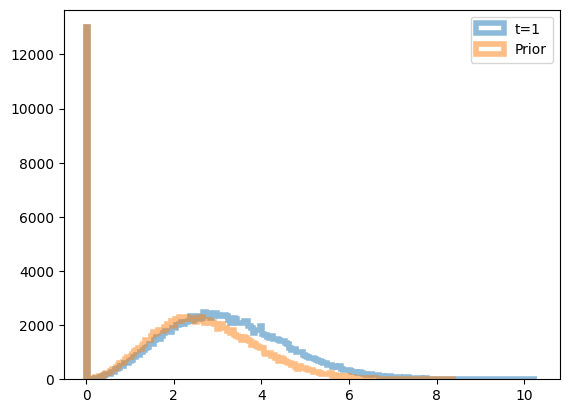

In [25]:
plt.hist(noisy_x_dist.view(-1).cpu().numpy(), bins=200, alpha=0.5, density=False,
          histtype='step', linewidth=4, label='t=1')
plt.hist(x1_dists.view(-1).cpu().numpy(), bins=200, alpha=0.5, density=False,
         histtype='step', linewidth=4, label='Prior')

plt.legend()
plt.show()

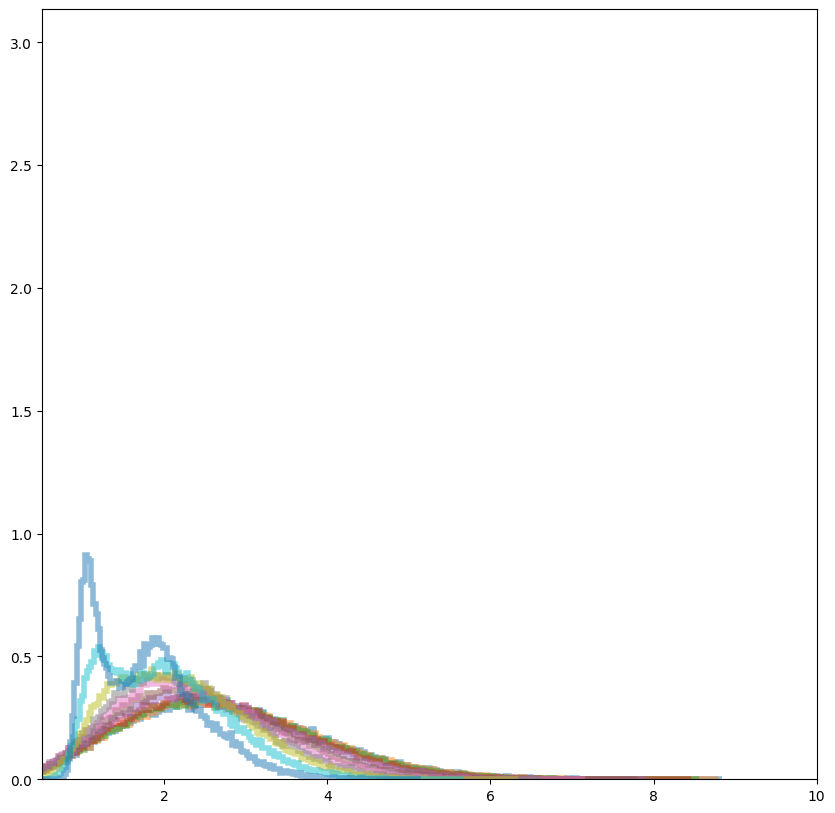

In [26]:
fig = plt.figure(figsize=(10, 10))
for i in range(0, 1000, 99):
    pred_dists = interatomic_dist(samples_pred[i].reshape(-1, n_nodes, dim)).detach()
    plt.hist(pred_dists.view(-1).cpu().numpy(), bins=200, alpha=0.5, density=True,
          histtype='step', linewidth=4)
plt.xlim(0.5, 10)
plt.show()

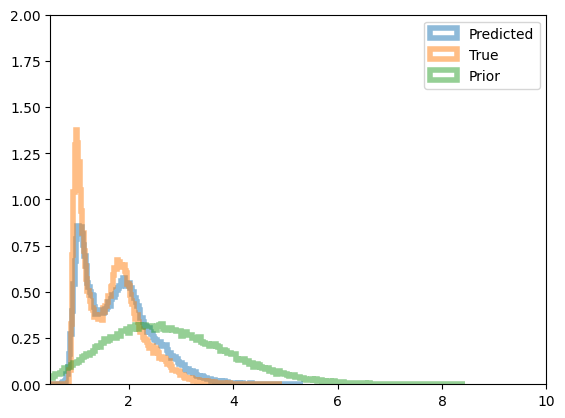

In [28]:
pred_dists = interatomic_dist(samples_pred[-1].reshape(-1, n_nodes, dim)).detach()
test_dists = interatomic_dist(test_data.reshape(-1, n_nodes, dim))
x1_dists = interatomic_dist(x1_samples.reshape(-1, n_nodes, dim)).detach()

plt.hist(pred_dists.view(-1).cpu().numpy(), bins=200, alpha=0.5, density=True,
          histtype='step', linewidth=4, label='Predicted')
plt.hist(test_dists.view(-1).cpu().numpy(), bins=200, alpha=0.5, density=True,
          histtype='step', linewidth=4, label='True')
plt.hist(x1_dists.view(-1).cpu().numpy(), bins=200, alpha=0.5, density=True,
         histtype='step', linewidth=4, label='Prior')

plt.xlim(0.5, 10)
plt.ylim(0, 2)
plt.legend()
plt.show()

In [ ]:
def plot_score_norms(noise_schedule, num_mc_samples=100):
    samples = target.sample((2048,))
    times = torch.linspace(0, 1, 20, device=device)
    
    mean_norms, std_norms = [], []
    for t in tqdm(times, position=0, leave=True):
        h_t = noise_schedule.h(t).unsqueeze(0)

        # noisy sample: x(t)
        noisy_x = torch.normal(samples, h_t.unsqueeze(1) ** 0.5)
        estimated_score = torch.cat([
            estimate_grad_Rt(noisy_x, t.repeat(len(noisy_x)), noise_schedule, num_mc_samples=num_mc_samples).detach().unsqueeze(0)
            for _ in range(10)
        ]).mean(0)
        
        norms = torch.linalg.vector_norm(estimated_score, dim=-1)
        
        mean_norms.append(norms.mean())
        std_norms.append(norms.std())
        
        
    mean_norms = torch.tensor(mean_norms).cpu()
    std_norms = torch.tensor(std_norms).cpu()
    
    plt.plot(times.cpu(), mean_norms)
    plt.fill_between(times.cpu(), mean_norms - std_norms, mean_norms + std_norms, alpha=0.4)
    
    plt.xlabel(r'$t$')
    plt.ylabel(r"$\|\nabla \log E[R(x')]\|_2^2$")
    #plt.yscale('log')
    plt.show()
    
    return mean_norms

###  NLL

In [163]:
def drift(x, t):
    with torch.enable_grad():
        x.requires_grad = True
        if follow_estimate:
            f = estimate_grad_Rt(x, t, noise_schedule, num_mc_samples=100)
            norm = torch.linalg.vector_norm(f, dim=-1)
            max_norm = 50
            clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
            # print(t, (max_norm < (norm + 1e-6)).sum())
            f = f * clip_coef.unsqueeze(-1)
            f = -0.5 * noise_schedule.g(t)**2 * f
        else:
            f = - 0.5 * beta * true_grad_Rt(x, t, beta)
        
    return f

In [164]:
def prior_dist(beta):
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(39).to(device), torch.eye(39).to(device) * beta
    )
    return dist

In [165]:
sigma = np.sqrt(1.5)
beta = sigma ** 2

follow_estimate = True
reverse_time = False

In [167]:
def div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = jacrev(u)
    # def div(x):
    #     J_x = J(x)
    #     tr =  torch.trace(J_x)
    #     print(torch.diag(J_x).sum())
    #     return tr
    # return div
    return lambda x: torch.trace(J(x))

def output_and_div(vecfield, x):
    if follow_estimate:
        dx = torch.vmap(vecfield, randomness="different")(x)
    else:
        dx = vecfield(x)
    
    if reverse_time:
        div = torch.zeros((x.shape[0]), device=device)
    else:
        div = torch.vmap(div_fn(vecfield), randomness="different")(x.clone().detach().requires_grad_(True))
    return dx, div

In [168]:
import gc
torch.cuda.empty_cache()
gc.collect()

2967

In [169]:
n_nodes = 13
dim = 3

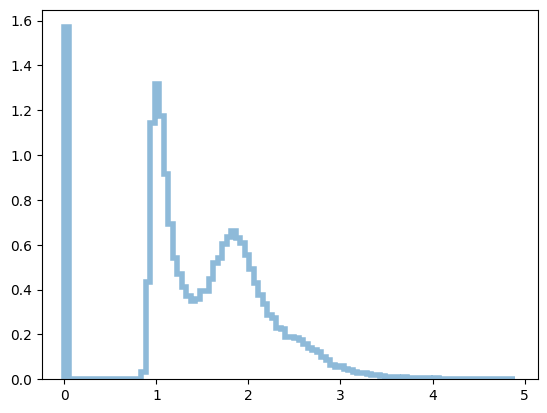

In [170]:
samples_all_2 = np.load('data/all_data_LJ13-2.npy')
test_data = samples_all_2[len(samples_all_2)//2:]
test_data = sample_from_array(test_data, 1000)
del samples_all_2
test_data = torch.tensor(test_data, device=device)
test_dists = interatomic_dist(test_data.reshape(-1, n_nodes, dim))
plt.hist(test_dists.view(-1).cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4)
plt.show()

In [171]:
def odefunc(t, x_in):
    x = x_in[..., :-1].clone().detach().requires_grad_(True)
    t = t.to(device)
    vecfield = lambda x: drift(x, t)
    dx, div = output_and_div(vecfield, x)
    div = div.reshape(-1, 1)
    return torch.cat([dx, div], dim=-1)

with torch.no_grad():
    if reverse_time:
        x1 = torch.randn(1024, 39).to(device) * sigma
        time = torch.linspace(1, 0, 1000).to(device)
    else:
        x1 = test_data
        time = torch.linspace(0, 1, 100).to(device)
    state1 = torch.cat([x1, torch.zeros_like(x1[..., :1])], dim=-1)
    state1.requires_grad = True
    state0 = odeint(odefunc, state1, t=time, method="euler")[-1]

    x0, logdetjac = state0[..., :-1], state0[..., -1]
    p0 = prior_dist(beta)
    logp0 = p0.log_prob(x0)
    logp1 = -(logp0 + logdetjac)

tensor(0., device='cuda:0') BatchedTensor(lvl=1, bdim=0, value=
    tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
            0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
            1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
            1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
            0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
            1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
            0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
            0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
            1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
            0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
            

KeyboardInterrupt: 

In [152]:
p0 = prior_dist(beta)
logp0 = p0.log_prob(x0.view(-1, 39))
logp1 = -(logp0 + logdetjac)

In [153]:
print("logp0", logp0.mean())
print("logdetjac", logdetjac.mean())
print("logp1", logp1.mean())

logp0 tensor(-55.0027, device='cuda:0')
logdetjac tensor(21.3578, device='cuda:0')
logp1 tensor(33.6449, device='cuda:0')


In [126]:
x0_true = torch.randn((1000, n_nodes*dim), device=device) * np.sqrt(beta)
true_logp0 = p0.log_prob(x0_true.view(-1, 39))
print("true_logp0", true_logp0.mean())

true_logp0 tensor(-63.3446, device='cuda:0')


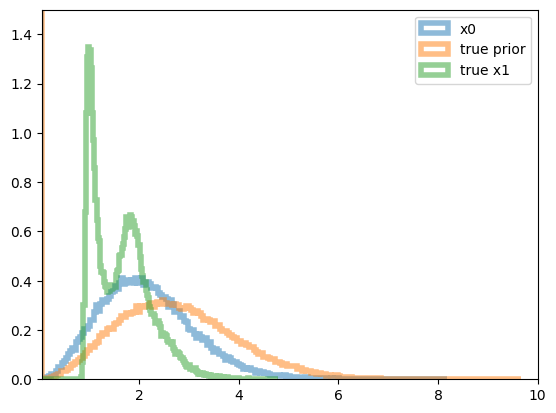

In [154]:
x0 = x0.reshape(-1, n_nodes, dim)
x0_dists = interatomic_dist(x0)
x0_true_dists = interatomic_dist(x0_true.reshape(-1, n_nodes, dim)).detach()


plt.hist(x0_dists.view(-1).detach().cpu().numpy(), bins=200, alpha=0.5, density=True, 
         histtype='step', linewidth=4, label='x0')
plt.hist(x0_true_dists.view(-1).detach().cpu().numpy(), bins=200, alpha=0.5, density=True,
          histtype='step', linewidth=4, label='true prior') 
plt.hist(test_dists.view(-1).cpu().numpy(), bins=200, alpha=0.5, density=True,
          histtype='step', linewidth=4, label='true x1')
plt.xlim(0.05, 10)
plt.ylim(0, 1.5)
plt.legend()
plt.show()

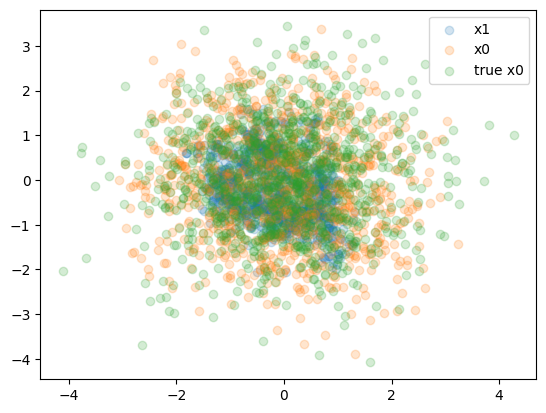

In [48]:
x1 = x1.reshape(-1, n_nodes, dim)
x0_true = x0_true.reshape(-1, n_nodes, dim)
for i in range(1):
    plt.scatter(x1[:, i, 0].detach().cpu(), x1[:, i, 1].detach().cpu(), alpha=0.2, label='x1')
    plt.scatter(x0[:, i, 0].detach().cpu(), x0[:, i, 1].detach().cpu(), alpha=0.2, label='x0')
    plt.scatter(x0_true[:, i, 0].detach().cpu(), x0_true[:, i, 1].detach().cpu(), alpha=0.2, label='true x0')

    plt.legend()

In [342]:
for i in range(10):
    plt.scatter(x0[:, i, 0].detach().cpu(), x0[:, i, 1].detach().cpu(), alpha=0.1)

IndexError: too many indices for tensor of dimension 2